In [1]:
import os
import keyring

# API KEY
OPENAI_API_KEY = keyring.get_password('openai', 'key_for_mac')
ANTHROPIC_API_KEY = keyring.get_password('anthropic', 'key_for_mac')
TAVILY_API_KEY = keyring.get_password('tavily', 'key_for_mac')

os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
os.environ['ANTHROPIC_API_KEY'] = ANTHROPIC_API_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

# Set up LangSmith observability
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = "https://api.smith.langchain.com"
os.environ['LANGCHAIN_API_KEY'] = keyring.get_password('langsmith', 'blogbot')
os.environ['LANGCHAIN_PROJECT'] = "proj-blog-bot"

In [2]:
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic

llm_anthropic = ChatAnthropic(model="claude-3-5-haiku-latest", temperature=0.5)
llm_openai = ChatOpenAI(model="gpt-4o-mini", temperature=0.5)

In [3]:
from planner import Planner
from researcher import Researcher
from coder import Coder
from writer import Writer
from state import State
from supervisor import Supervisor

state = State()

structure = "hierarchical"

# nodes
planner = Planner(llm=llm_anthropic, structure=structure)
researcher = Researcher(llm=llm_openai, structure=structure)
coder = Coder(llm=llm_openai, structure=structure)
writer = Writer(llm=llm_anthropic, structure=structure)
# supervisor = Supervisor(llm=llm_openai)


In [4]:
from typing import Annotated, Literal, Optional

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities.python import PythonREPL
from langchain_core.messages import HumanMessage
from langchain_anthropic import ChatAnthropic
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import create_react_agent
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command

from state import State

import os
import keyring
import json

members = ["planner", "researcher", "coder", "writer"]
options = members + ["FINISH"]

# Supervisor
supervisor_prompt = """ 
You are a supervisor managing a blog posting team responsible for **researching topics, gathering data, writing, and structuring blog posts**. 
Your team consists of the following specialists:
{members}

Your primary responsibility is to **assign tasks to the most suitable specialist based on their expertise** and **ensure the quality of their output**.

---

## **🔹 Instructions**
- **Always respond in English.**
- Assign tasks to the **most appropriate** specialist based on their role.
- Ensure the process is **efficient and iterative**, refining outputs when necessary.

---

## **🔹 Team Roles & Responsibilities**
1. **Planner** – Analyzes the user’s subject and outlines key topics for research.
2. **Researcher** – Gathers credible sources, factual data, and background information.
3. **Coder** – Implements any necessary code snippets or technical explanations.
4. **Writer** – Drafts, structures, and refines the final blog post.

---

## **🔹 Responsibilities**
### **1. Manage Task Assignment**
- Evaluate the **subject** provided by the user and determine which specialist should act first.
- Monitor the **progress** of research, writing, and content structuring.
- If any member’s output is **incomplete or lacks quality**, request refinements.

### **2. Evaluate Outputs**
- Review the **work** submitted by each specialist.
- Determine whether each step has been **adequately completed** with sufficient depth and clarity.
- Ensure all gathered information is well-structured and relevant to the blog post.

### **3. Complete the Process**
- Once the **blog post is fully written and reviewed**, respond with `"FINISH"` to conclude the task.

---

## **🔹 Output Format**
Respond with a **valid JSON object** formatted as follows:
Never include other texts.
```json
{
    "next": "researcher",  // Replace with "planner", "coder", "writer", or "FINISH"
    "instructions": "Provide additional research on AI trends in 2024."
}

"""

def supervisor_node(state: State) -> Command[Literal[tuple(members + [END])]]:
    messages = [
        {"role": "system", "content": supervisor_prompt},
    ] + state["messages"]
    response = llm_anthropic.invoke(messages)
    parsed_response = json.loads(response.content)
    goto = parsed_response["next"]
    if parsed_response["instructions"]:
        instructions = parsed_response.get("instructions", "No instructions provided.")
    if goto == "FINISH":
        goto = END
        
        
    # Append instructions to message to maintain full context
    # updated_messages = state["messages"] + [HumanMessage(content=instructions, name="supervisor")]
    return Command(goto=goto, update={"messages": HumanMessage(content=instructions, name="supervisor"), "next": goto, "instructions": instructions})

In [5]:
from planner import Planner
from researcher import Researcher
from coder import Coder
from writer import Writer

from langgraph.graph import StateGraph, START, END

# Define workflow
builder = StateGraph(State)
builder.add_node("supervisor", supervisor_node)
builder.add_node("planner", planner.create_node)
builder.add_node("researcher", researcher.create_node)
builder.add_node("coder", coder.create_node)
builder.add_node("writer", writer.create_node)
builder.add_edge(START, "supervisor")
for member in members:
    builder.add_edge(member, "supervisor")
graph = builder.compile()

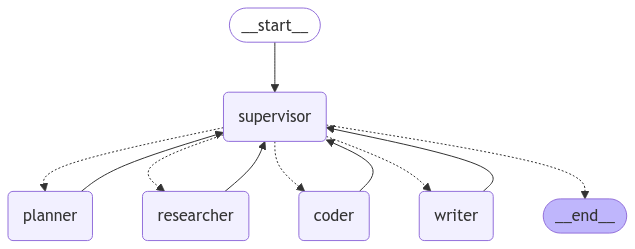

In [6]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
for s in graph.stream(
    {"messages": [("user", "Introduce agentic RAG")]}
):
    print(s)
    print("----------")

{'supervisor': {'messages': HumanMessage(content='Create a comprehensive outline for a blog post about Agentic Retrieval-Augmented Generation (Agentic RAG), covering key concepts, differences from traditional RAG, implementation strategies, and potential applications.', additional_kwargs={}, response_metadata={}, name='supervisor', id='7b530276-476f-4689-a062-21289de00960'), 'next': 'planner', 'instructions': 'Create a comprehensive outline for a blog post about Agentic Retrieval-Augmented Generation (Agentic RAG), covering key concepts, differences from traditional RAG, implementation strategies, and potential applications.'}}
----------
{'planner': {'messages': HumanMessage(content='Based on the research, here\'s a comprehensive outline for the blog post:\n\n# Title\n"Agentic RAG: Revolutionizing AI Information Retrieval and Generation"\n\n# Objectives\nTo provide a comprehensive overview of Agentic Retrieval-Augmented Generation (Agentic RAG), explaining its advanced capabilities, k

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT